In [1]:
import gluoncv as gcv
from gluoncv.data import VOCDetection
%matplotlib inline
import matplotlib.pyplot as plt
from gluoncv.utils import viz
from mxnet import autograd, gluon
import mxnet as mx
import time

In [2]:
classes = ['1', '2', '3', '4', '5', '6', '7', '8']

In [3]:
class VOCLike(VOCDetection):
    CLASSES = classes
    def __init__(self, root, splits, transform=None, index_map=None, preload_label=True):
        super(VOCLike, self).__init__(root, splits, transform, index_map, preload_label)

dataset = VOCLike(root='input/train/', splits=(('location1', 'trainval'),('location2', 'trainval'),('location3', 'trainval'),('location4', 'trainval'),('location5', 'trainval'),('location6', 'trainval'),('location7', 'trainval')))
print('length of dataset:', len(dataset))
print('label example:')
print(dataset[0][1])

length of dataset: 6503
label example:
[[ 14. 494. 598. 598.   6.   0.]]


In [4]:
image, label = dataset[2]

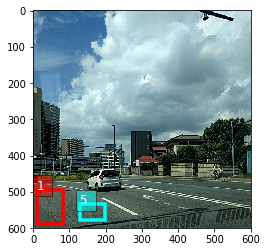

In [5]:
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
plt.show()

In [6]:
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_voc', pretrained=True)

In [7]:
net.reset_class(classes)

In [8]:
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes,
    pretrained_base=False, transfer='voc')

In [9]:
def get_dataloader(net, train_dataset, data_shape, batch_size, num_workers):
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
    width, height = data_shape, data_shape
    # use fake data to generate fixed anchors for target generation
    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width)))
    batchify_fn = Tuple(Stack(), Stack(), Stack())  # stack image, cls_targets, box_targets
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
        batch_size, True, batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
    return train_loader

train_data = get_dataloader(net, dataset, 512, 16, 0)

In [19]:
mx.test_utils.list_gpus()

range(0, 1)

In [11]:
def wrapper(gen):
  while True:
    try:
      yield next(gen)
    except StopIteration:
      raise
    except Exception as e:
      print(e)
      pass

In [37]:
try:
    a = mx.nd.zeros((1,), ctx=mx.gpu(0))
    ctx = [mx.gpu(0)]
except:
    ctx = [mx.cpu()]

In [13]:
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})

mbox_loss = gcv.loss.SSDMultiBoxLoss()
ce_metric = mx.metric.Loss('CrossEntropy')
smoothl1_metric = mx.metric.Loss('SmoothL1')

for epoch in range(0, 10):
    ce_metric.reset()
    smoothl1_metric.reset()
    tic = time.time()
    btic = time.time()
    net.hybridize(static_alloc=True, static_shape=True)
    for i, batch in wrapper(enumerate(train_data)):
        batch_size = batch[0].shape[0]
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
        with autograd.record():
            cls_preds = []
            box_preds = []
            for x in data:
                cls_pred, box_pred, _ = net(x)
                cls_preds.append(cls_pred)
                box_preds.append(box_pred)
            sum_loss, cls_loss, box_loss = mbox_loss(
                cls_preds, box_preds, cls_targets, box_targets)
            autograd.backward(sum_loss)
        # since we have already normalized the loss, we don't want to normalize
        # by batch-size anymore
        trainer.step(1)
        ce_metric.update(0, [l * batch_size for l in cls_loss])
        smoothl1_metric.update(0, [l * batch_size for l in box_loss])
        name1, loss1 = ce_metric.get()
        name2, loss2 = smoothl1_metric.get()
        if i % 20 == 0:
            print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
        btic = time.time()

[Epoch 0][Batch 0], Speed: 2.742 samples/sec, CrossEntropy=18.511, SmoothL1=4.034
too many indices for array


/home/wakanapo/.pyenv/versions/3.6.3/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: generator 'wrapper' raised StopIteration
  app.launch_new_instance()


[Epoch 1][Batch 0], Speed: 18.506 samples/sec, CrossEntropy=9.583, SmoothL1=2.148
[Epoch 1][Batch 20], Speed: 23.411 samples/sec, CrossEntropy=7.011, SmoothL1=2.215
[Epoch 1][Batch 40], Speed: 21.566 samples/sec, CrossEntropy=5.951, SmoothL1=2.151
[Epoch 1][Batch 60], Speed: 22.085 samples/sec, CrossEntropy=5.439, SmoothL1=2.090
[Epoch 1][Batch 80], Speed: 18.259 samples/sec, CrossEntropy=5.119, SmoothL1=2.034
[Epoch 1][Batch 100], Speed: 19.268 samples/sec, CrossEntropy=4.888, SmoothL1=2.022
[Epoch 1][Batch 120], Speed: 21.476 samples/sec, CrossEntropy=4.717, SmoothL1=2.008
[Epoch 1][Batch 140], Speed: 22.120 samples/sec, CrossEntropy=4.594, SmoothL1=1.986
[Epoch 1][Batch 160], Speed: 20.223 samples/sec, CrossEntropy=4.485, SmoothL1=1.958
[Epoch 1][Batch 180], Speed: 20.677 samples/sec, CrossEntropy=4.400, SmoothL1=1.950
[Epoch 1][Batch 200], Speed: 22.387 samples/sec, CrossEntropy=4.332, SmoothL1=1.932
[Epoch 1][Batch 220], Speed: 20.949 samples/sec, CrossEntropy=4.265, SmoothL1=1.91

[Epoch 7][Batch 280], Speed: 20.339 samples/sec, CrossEntropy=2.912, SmoothL1=1.455
[Epoch 7][Batch 300], Speed: 24.112 samples/sec, CrossEntropy=2.906, SmoothL1=1.459
[Epoch 7][Batch 320], Speed: 23.699 samples/sec, CrossEntropy=2.902, SmoothL1=1.457
[Epoch 7][Batch 340], Speed: 27.585 samples/sec, CrossEntropy=2.896, SmoothL1=1.449
too many indices for array
[Epoch 8][Batch 0], Speed: 24.459 samples/sec, CrossEntropy=2.591, SmoothL1=1.266
[Epoch 8][Batch 20], Speed: 22.471 samples/sec, CrossEntropy=2.919, SmoothL1=1.406
[Epoch 8][Batch 40], Speed: 17.596 samples/sec, CrossEntropy=2.901, SmoothL1=1.414
[Epoch 8][Batch 60], Speed: 22.030 samples/sec, CrossEntropy=2.852, SmoothL1=1.407
[Epoch 8][Batch 80], Speed: 21.384 samples/sec, CrossEntropy=2.849, SmoothL1=1.446
[Epoch 8][Batch 100], Speed: 23.582 samples/sec, CrossEntropy=2.849, SmoothL1=1.429
[Epoch 8][Batch 120], Speed: 22.703 samples/sec, CrossEntropy=2.842, SmoothL1=1.410
[Epoch 8][Batch 140], Speed: 18.405 samples/sec, CrossE

In [14]:
net.save_parameters('ssd_512_mobilenet1.0_fujifilm.params')

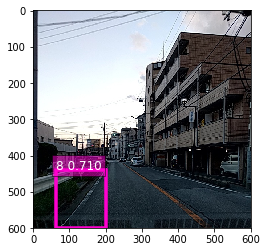

In [10]:
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes, pretrained_base=False)
net.load_parameters('ssd_512_mobilenet1.0_fujifilm.params')
x, image = gcv.data.transforms.presets.ssd.load_test('input/train/location1/JPEGImages/location1_00051363.jpg', 600)
cid, score, bbox = net(x)
ax = viz.plot_bbox(image, bboxes=bbox[0], scores=score[0], labels=cid[0], class_names=classes)
plt.show()

In [11]:
import xml.etree.ElementTree as ET


class PascalVOCGenerator():
  def __init__(self):
    self._root = ET.Element('annotations')
    self._tree = ET.ElementTree(self._root)

  def addImage(self, fileName, crackLabels):
    """Adds annotation tag for this file.
    crackLabels: array of cracks (sample: {name: 2, bb: (123 /*xmin*/, 264 /*ymin*/, 219/*xmax*/, 553 /*ymax*/)})
    difficult, truncated and pose are omitted from the output.
    """

    node = ET.SubElement(self._root, 'annotation')
    ET.SubElement(node, 'filename').text = fileName
    for crackLabel in crackLabels:
      obj = ET.SubElement(node, 'object')
      ET.SubElement(obj, 'name').text = str(classes[int(crackLabel['name'][0])])
      bndbox = ET.SubElement(obj, 'bndbox')
      ET.SubElement(bndbox, 'xmin').text = str(crackLabel['bb'][0])
      ET.SubElement(bndbox, 'ymin').text = str(crackLabel['bb'][1])
      ET.SubElement(bndbox, 'xmax').text = str(crackLabel['bb'][2])
      ET.SubElement(bndbox, 'ymax').text = str(crackLabel['bb'][3])

  def save(self, filePath):
    self._tree.write(filePath)

In [72]:
np_cid = cid.asnumpy()
np_bbox = bbox.asnumpy()
np_score = score.asnumpy()

In [74]:
objects = [{'name': np_cid[0][i], 'bb': np_bbox[0][i]} for i in range(len(np_score[0][np_score[0]>0.5]))]

In [75]:
pascalGenerator = PascalVOCGenerator()
pascalGenerator.addImage('0000.jpg', objects)
pascalGenerator.save('testtest.xml')

In [77]:
import os

In [78]:
path = 'input/test/'
images = os.listdir(path)

In [79]:
pascalGenerator = PascalVOCGenerator()
for img in images:
    pascalGenerator.addImage(img, objects)

['00058071.jpg',
 '00062273.jpg',
 '00017964.jpg',
 '00015985.jpg',
 '00004168.jpg',
 '00043948.jpg',
 '00061720.jpg',
 '00042090.jpg',
 '00022224.jpg',
 '00025813.jpg']

In [12]:
import os
import tqdm

In [13]:
path = 'input/test/'
images = os.listdir(path)

In [18]:
pascalGenerator = PascalVOCGenerator()
for img in tqdm.tqdm(images):
    x, image = gcv.data.transforms.presets.ssd.load_test(path+img, 600)
    cid, score, bbox = net(x)
    np_cid = cid.asnumpy()
    np_bbox = bbox.asnumpy()
    np_score = score.asnumpy()
    objects = [{'name': np_cid[0][i], 'bb': np_bbox[0][i]} for i in range(len(np_score[0][np_score[0]>0.3425]))]
    pascalGenerator.addImage(img, objects)
pascalGenerator.save('answer_t0.3425.xml')

100%|██████████| 1628/1628 [07:16<00:00,  3.76it/s]


[gpu(0)]